# Project Report: PLAIcraft

In [1]:
# Install if you are missing these packages!
# install.packages("caret")
# install.packages("kknn")

library(tidyverse)
library(scales)
library(repr)
library(tidymodels)
library(caret)
library(kknn)

options(repr.plot.height = 10, repr.plot.width = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor


── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.10     ✔ rsample      1.3.1 
✔ dials        1.4.2      ✔ tailor       0.1.0 
✔ infer        1.0.9      ✔ tune         2.0.1 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.3.3      ✔ work

A [research group](https://plai.cs.ubc.ca/) at UBC collected data about how people play video games using a [MineCraft server](https://plaicraft.ai/) and recording players' actions. 

Data regarding all the players' information was collected as players signed in to play the game. 

## 1) `Players` Dataset Description:

In [2]:
players <- read_csv("https://raw.githubusercontent.com/audreyw28/DSCI100-2025W1-004-42/refs/heads/main/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [3]:
#CALCULATING SUMMARY STATISTICS: RANGE, MEAN, STANDARD DEVIATION

players_range <- players|>
    reframe(played_hours_range = range(played_hours), 
              age_range = range(Age, na.rm = TRUE))
players_range

players_stats <- players|>
    summarize(played_hours_mean = round(mean(played_hours), 2),
              played_hours_sd = round(sd(played_hours), 2),
              age_mean = round(mean(Age, na.rm = TRUE), 2), 
              age_sd = round(sd(Age, na.rm = TRUE), 2))
players_stats

# sum(is.na(players))

played_hours_range,age_range
<dbl>,<dbl>
0.0,9
223.1,58


played_hours_mean,played_hours_sd,age_mean,age_sd
<dbl>,<dbl>,<dbl>,<dbl>
5.85,28.36,21.14,7.39




In the `players` dataset, there are:
- 196 observations, each of one player
- 7 variables:

| Variable | Type | Description |
|:---|:---|:---|
| experience | character | experience level of player |
| subscribe | logical | whether the player has subscribed to the game or not |
| hashedEmail | character | hashed email of player |
| played_hours | double | number of hours played (hours)|
| name | character | name of player |
| gender | character | gender of player |
| Age | double | age of player (years) |

`played_hours` has: 
- range of 0 - 223.1
- mean of 5.85
- standard deviation of 28.36

`Age` has:
- range of 9 - 58
- mean of 21.14
- standard deviation of 7.39

Issues exist in this dataset in that: 
- 2 player ages were missing (NA) $ \rightarrow $ decreased accuracy when performing summary statistics for `Age`
- the experience levels were self-declared by players $ \rightarrow $ could be biased

## 2) Investigated Question:

- Can `Age`, `played_hours`, and `experience` predict `subscribe` in the `players` dataset?

The `players` dataset will make this regression problem possible by providing a sufficient number of observations (196 - 2 NAs) of players and their respective `played_hours`, `Age`, `experience`and `subscribe`. 

## 3) Exploratory Data Analysis

The dataset is tidy; variables of interest (`played_hours`, `Age`, `experience` and `subscribe`) are in separate columns, and each observation is one player. 

To cater the data to answering my specific question, we will: 
- select for my interested variables
- drop NAs
- convert any non-numeric (character) variables to factor variables since they will be used as categorical variables
- assign levels to `experience` since it can be ordered
- recode the `subscribe` variable into "Yes" and "No" to increase the readability of our analysis

In [4]:
players <- players |>
    select(subscribe, Age, played_hours, experience)|>
    drop_na()|>
    mutate(experience = factor(experience,
                               levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")), 
           subscribe = as_factor(subscribe),
           subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
head(players)

subscribe,Age,played_hours,experience
<fct>,<dbl>,<dbl>,<fct>
Yes,9,30.3,Pro
Yes,17,3.8,Veteran
No,17,0.0,Veteran
Yes,21,0.7,Amateur
Yes,21,0.1,Regular
Yes,17,0.0,Amateur


In [5]:
# CALCULATING NUMBER AND PERCENTAGE OF SUBSCRIBED AND NOT SUBSCRIBED OBSERVATIONS
num_obs <- nrow(players)
players |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)

subscribe,count,percentage
<fct>,<int>,<dbl>
No,52,26.80412
Yes,142,73.19588


The response/target variable (`subscribe`) is not extremely imbalanced. 

Warning message in scale_y_log10(labels = label_comma()):
"log-10 transformation introduced infinite values."


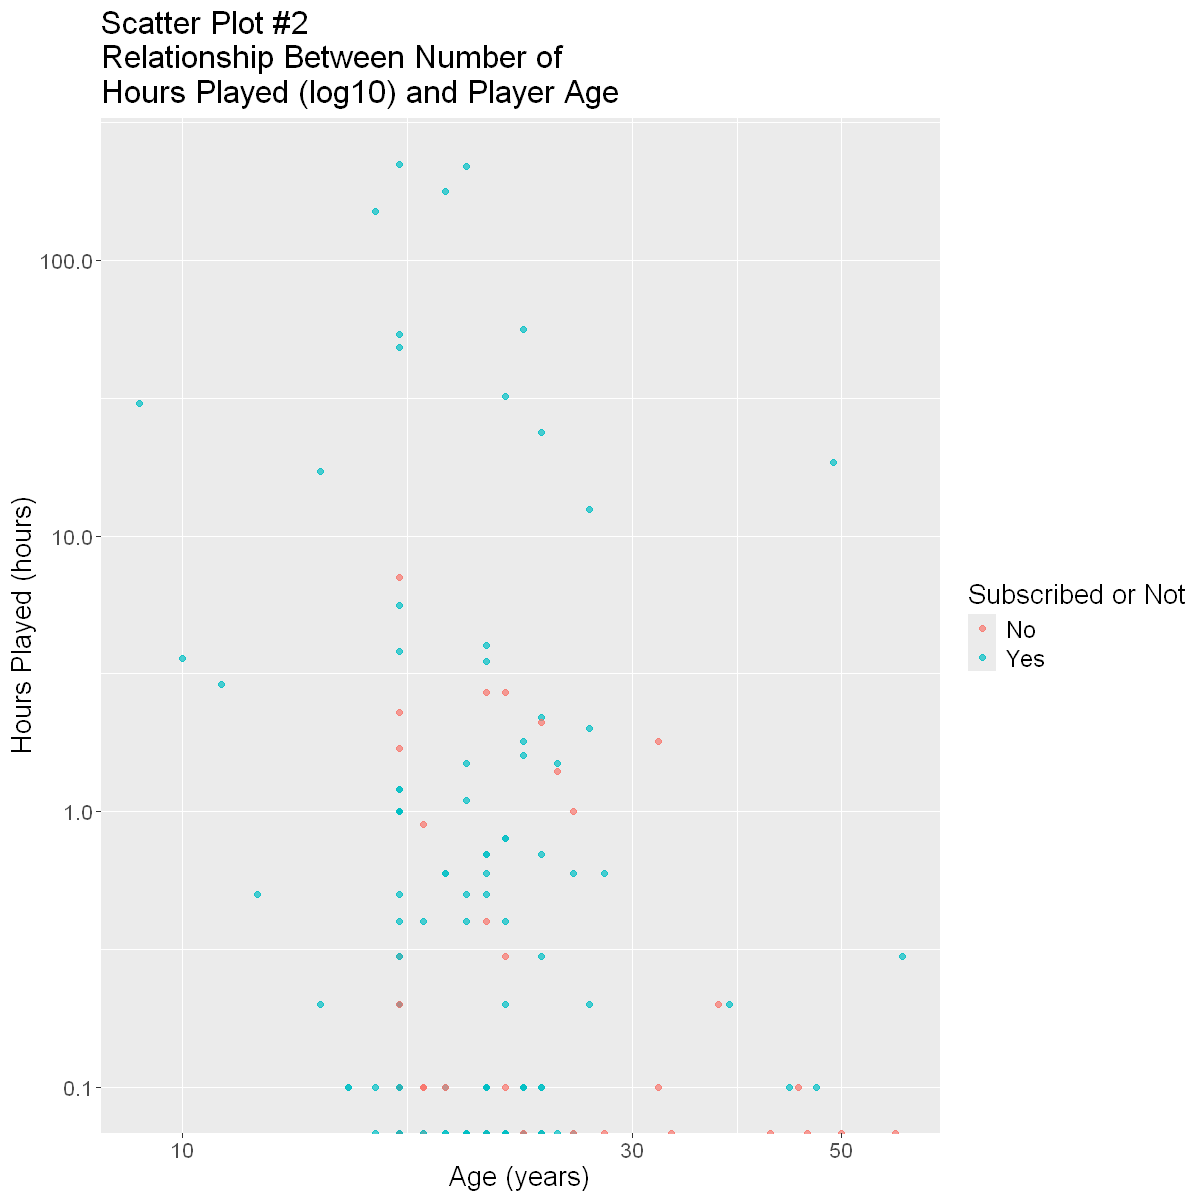

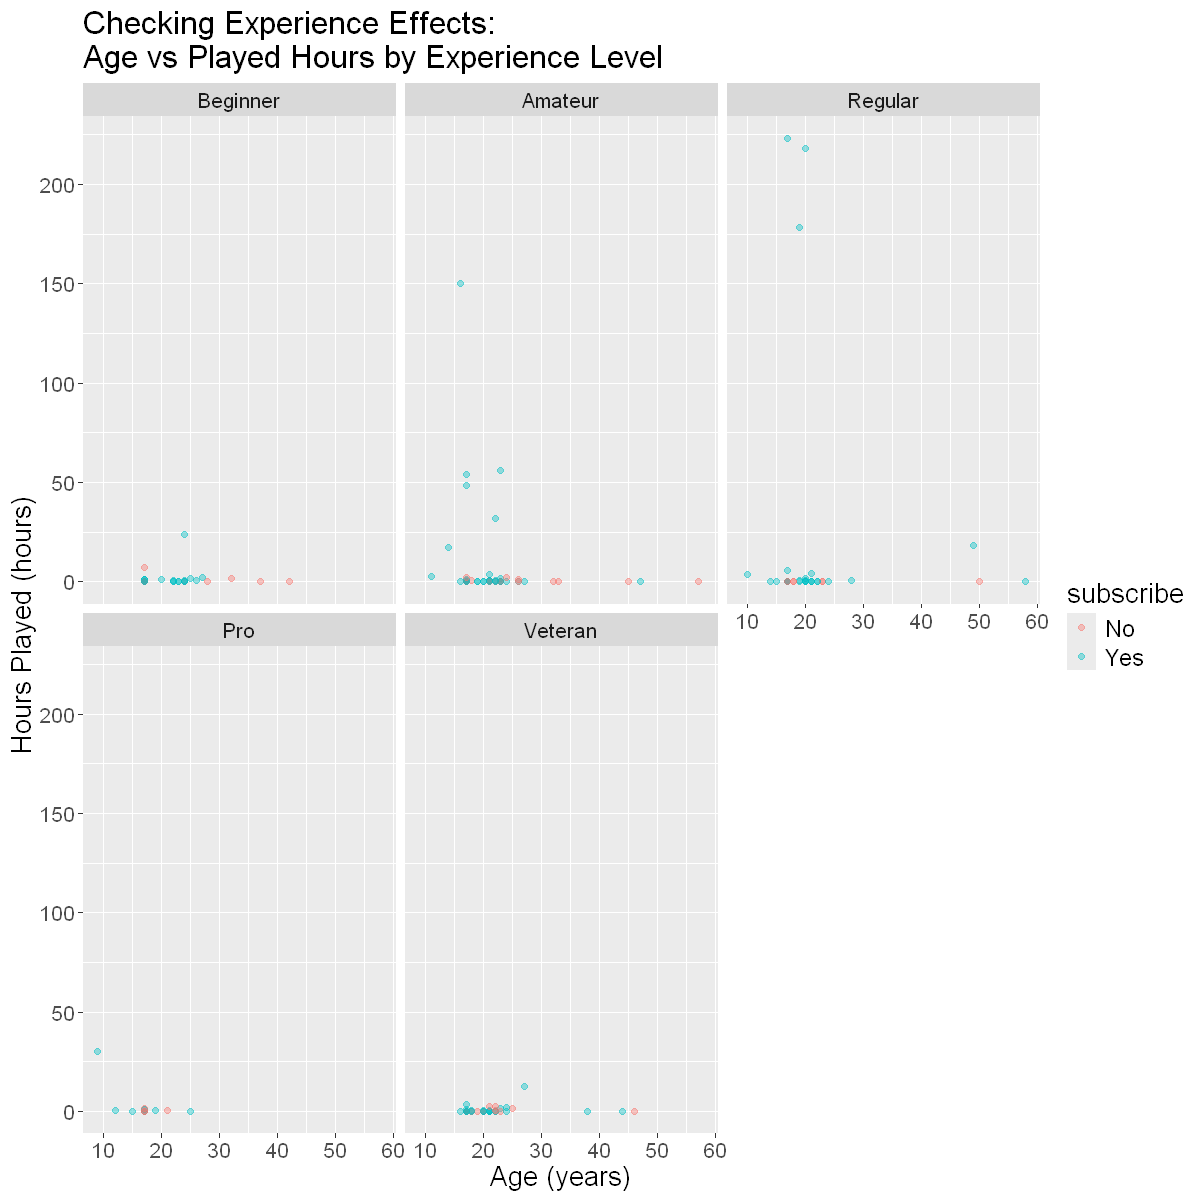

In [6]:
trend_log <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.7) +
    scale_color_discrete(name = "Subscribed or Not") +
    labs(x = "Age (years)", 
         y = "Hours Played (hours)", 
         title = "Scatter Plot #2\nRelationship Between Number of\nHours Played (log10) and Player Age") +
    theme(text = element_text(size = 16), 
         legend.text = element_text(size = 14),
         legend.title = element_text(size = 16)) +
    scale_y_log10(labels = label_comma())+
    scale_x_log10(labels = label_comma())
trend_log

trend_with_experience <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.4) +
    facet_wrap(~ experience) +
    labs(title = "Checking Experience Effects:\nAge vs Played Hours by Experience Level",
         x = "Age (years)",
         y = "Hours Played (hours)") +
        theme(text = element_text(size = 16), 
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 16))
trend_with_experience

add description...

In [7]:
# CHECKING NUMBER OF OBSERVATIONS IN EACH EXPERIENCE LEVEL
# players |>
# group_by(experience) |>
# summarize(count = n())

## 4) Methods and Results

In [8]:
set.seed(1)

# split data into training and testing set
players_split <- initial_split(players, prop = 0.70, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

### 1st model: using `Age`, `played_hours` and `experience` to predict

We will first tune the model to find the K neighbors value with highest accuracy.

In [9]:
# create recipe to tune for best neighbors
# players_recipe1.0 <- recipe(subscribe ~ Age + played_hours + experience, data = players_train) |>
#     step_scale(all_numeric()) |>
#     step_center(all_numeric())
# players_recipe1.0

players_recipe1.0 <- recipe(subscribe ~ Age + played_hours + experience, 
                            data = players_train) |>
    step_dummy(experience) |>      # convert `experience` to dummies
    step_center(all_numeric_predictors()) |>     # center numeric columns
    step_scale(all_numeric_predictors())         # scale numeric columns

In [10]:
set.seed(100)

#number of neighbors to cross validate on (UPPER LIMIT FOR NEIGHBORS = 1/5th of training set size)
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

# model specification for tuning
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_tune

# number of folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# fit model and collect metrics dataframe
knn_results1.0 <- workflow() |>
       add_recipe(players_recipe1.0) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals) |>
       collect_metrics() |>
       filter(.metric == "accuracy")
head(knn_results1.0)

# find k with highest accuracy
best_k1 <- knn_results1.0 |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k1

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5698820,5,0.035273613,pre0_mod01_post0
2,accuracy,binary,0.5701465,5,0.025521830,pre0_mod02_post0
3,accuracy,binary,0.6308303,5,0.036637164,pre0_mod03_post0
4,accuracy,binary,0.6310948,5,0.035783091,pre0_mod04_post0
5,accuracy,binary,0.7040904,5,0.008256593,pre0_mod05_post0
6,accuracy,binary,0.7040904,5,0.008256593,pre0_mod06_post0


[1] 11

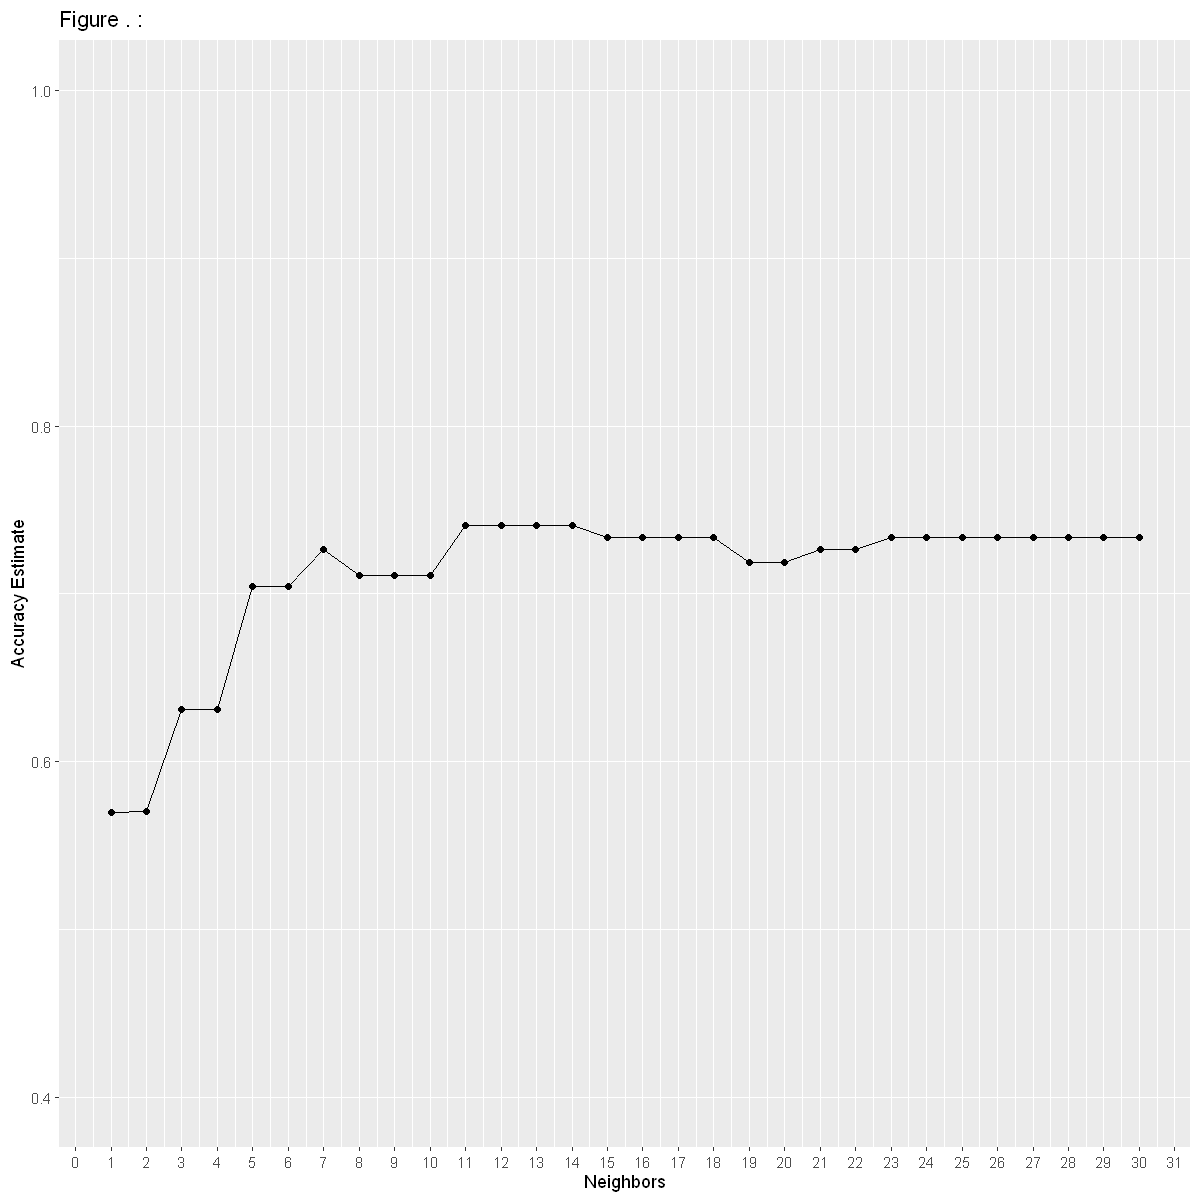

In [11]:
# plot of estimated accuracy versus number of neighbors
accuracy_versus_k1.0 <- ggplot(knn_results1.0, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate", title = "Figure . : ") +
       scale_x_continuous(breaks = seq(0, 40, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k1.0

**Since the K with highest accuracy is 11, we will use k=11 to create a new model to test for accuracy on the testing set.**

In [12]:
# model specification for final value
knn_spec1.1 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k1) |>
    set_engine("kknn") |>
    set_mode("classification")

# fit model and collect metrics dataframe
# use recipe from above
knn_results1.1 <- workflow() |>
       add_recipe(players_recipe1.0) |>
       add_model(knn_spec1.1) |>
       fit(players_train)

# find accuracy of the model by making it predict the testing set
players_predictions1 <- predict(knn_results1.1, players_test) |>
  bind_cols(players_test) |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_predictions1

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


**For using `Age`, `played_hours` and `experience` to predict `subscribe` the accuracy is around 73%.**

### 2nd model: using `Age` and `played_hours` to predict

In [13]:
# create recipe to tune for best neighbors
players_recipe2.0 <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
players_recipe2.0



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [14]:
set.seed(100)

# use the same knn_tune, players_vfold, and kvals as the 1st model
# fit model and collect metrics dataframe
knn_results2.0 <- workflow() |>
       add_recipe(players_recipe2.0) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals) |>
       collect_metrics() |>
       filter(.metric == "accuracy")
head(knn_results2.0)

# find k with highest accuracy
best_k2 <- knn_results2.0 |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4370167,5,0.01255689,pre0_mod01_post0
2,accuracy,binary,0.4370167,5,0.01255689,pre0_mod02_post0
3,accuracy,binary,0.5407814,5,0.03386500,pre0_mod03_post0
4,accuracy,binary,0.5481888,5,0.02906724,pre0_mod04_post0
5,accuracy,binary,0.5789174,5,0.03444997,pre0_mod05_post0
6,accuracy,binary,0.5866097,5,0.03916835,pre0_mod06_post0


[1] 18

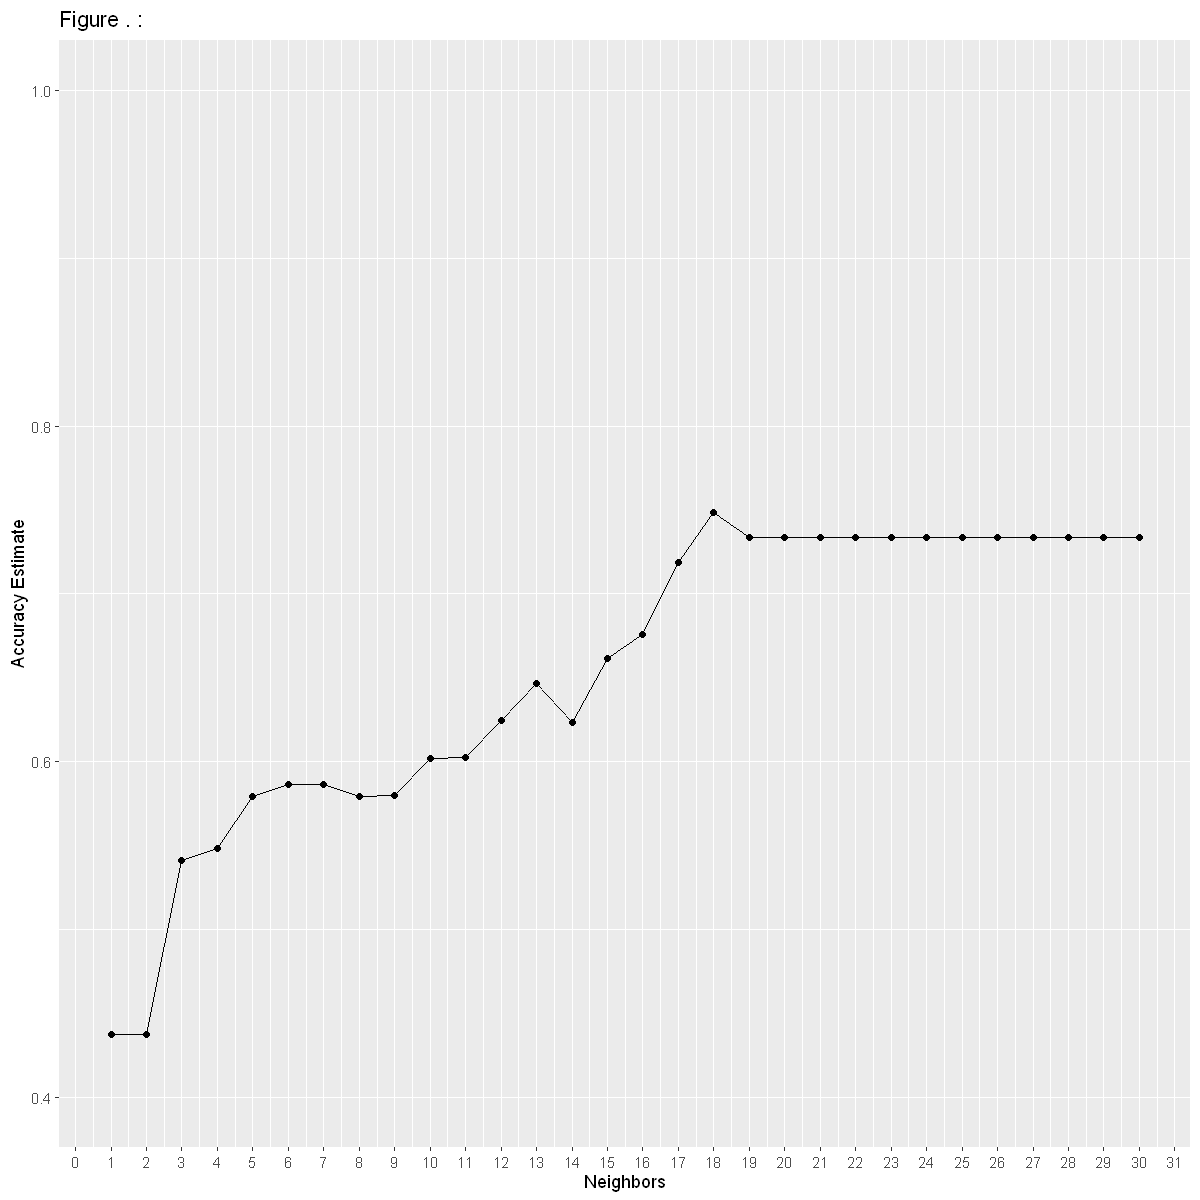

In [15]:
# plot of estimated accuracy versus number of neighbors
accuracy_versus_k2.0 <- ggplot(knn_results2.0, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate", title = "Figure . : ") +
       scale_x_continuous(breaks = seq(0, 40, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
accuracy_versus_k2.0

**Since the K with highest accuracy is 18, we will use k=18 to create a new model to test for accuracy on the testing set.**

In [16]:
# model specification for final value
knn_spec2.1 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k2) |>
    set_engine("kknn") |>
    set_mode("classification")

# fit model and collect metrics dataframe
# use recipe from above
knn_results2.1 <- workflow() |>
       add_recipe(players_recipe2.0) |>
       add_model(knn_spec2.1) |>
       fit(players_train)

# find accuracy of the model by making it predict the testing set
players_predictions2 <- predict(knn_results2.1, players_test) |>
  bind_cols(players_test) |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
players_predictions2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7457627


**For using `Age` and `played_hours` to predict `subscribe` the accuracy is around 75%.**

lacking analysis visualization

### 5) Discussion

- summarize what was found:
  - using 3 predictors yielded a lower accuracy than using 2 predictors
  - number of neighbors are pretty similar (11vs18) compared on the scale of total observations (196)
  - since using 2 predictors gave a higher accuracy, but uses more neighbors, that means creating and using the model will use a significantly larger amount of memory to run. therefore, it is crucial that we balance between the simplicity and accuracy. 
- discuss whether this is what you expected to find:
  - Overall accuracy: yes, since through EDA and common sense logic, the played hours and age should be able to help us predict in whether someone will subscribe or not (these are reasonable predictors, compared to gender which is definitely not informative)
  - Comparing models: yes, this is what we expected, since through the facet grid graph, we didn't see any distinct relationship between each experience level, so it was likely that experience isn't a useful predictor. However, it was still tested since there could be a relationship that we could not interpret visually with the 2D graph. 
  - also discuss why the model doesnt have a higher accuracy
- discuss what impact could such findings have:
  - Be able to help the research team in predicting whether people will subscribe in the future?if someone subscribes that means higher engagement, and more likely to return to the game. 
- discuss what future questions could this lead to: